<a href="https://colab.research.google.com/github/23wj1a0541/Masai-Python-Major-Project/blob/main/Kuldeep_Masai_Python_Major_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run this cell in Colab to upload the CSV
from google.colab import files
uploaded = files.upload()  # pick your CSV file
# After upload, if your file is e.g. attendance.csv:
csv_path = list(uploaded.keys())[0]
csv_path


Saving attendance.csv to attendance.csv


'attendance.csv'

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(csv_path)

# Standardize column names (strip spaces, fix common variants)
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

expected = {'Roll_No','Date','Enrolled','Absent','Present','Released'}
print("Columns:", set(df.columns))
missing = expected - set(df.columns)
assert not missing, f"Missing columns: {missing}"

# Parse Date
df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d', errors='coerce')

# Coerce numeric columns
for col in ['Enrolled','Absent','Present','Released']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Basic peek
print(df.head())
print(df.info())


Columns: {'Present', 'Absent', 'Released', 'Date', 'Enrolled', 'Roll_No'}
   Roll_No       Date  Enrolled  Absent  Present  Released
0        1 2018-09-05       172      19      153         0
1        2 2018-09-06       171      17      154         0
2        3 2018-09-07       172      14      158         0
3        4 2018-09-12       173       7      166         0
4        5 2018-09-13       173       9      164         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Roll_No   600 non-null    int64         
 1   Date      600 non-null    datetime64[ns]
 2   Enrolled  600 non-null    int64         
 3   Absent    600 non-null    int64         
 4   Present   600 non-null    int64         
 5   Released  600 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 28.3 KB
None


In [ ]:
issues = []

# Negative checks
neg_mask = (df[['Enrolled','Absent','Present','Released']] < 0).any(axis=1)
if neg_mask.any():
    issues.append(("NEGATIVE_VALUES", df.loc[neg_mask]))

# Sum constraint
sum_mask = (df['Absent'] + df['Present'] + df['Released']) > df['Enrolled']
if sum_mask.any():
    issues.append(("OVER_ALLOCATION", df.loc[sum_mask]))

# Enrolled==0 sanity
zero_enrolled_bad = (df['Enrolled'] == 0) & ((df['Absent']>0) | (df['Present']>0) | (df['Released']>0))
if zero_enrolled_bad.any():
    issues.append(("ZERO_ENROLLED_WITH_ACTIVITY", df.loc[zero_enrolled_bad]))

# Null dates
null_date = df['Date'].isna()
if null_date.any():
    issues.append(("NULL_DATES", df.loc[null_date]))

print(f"Found {len(issues)} issue categories.")
for tag, subdf in issues:
    print(f"\n--- {tag} ({len(subdf)}) ---")
    display(subdf.head())

# Optionally drop bad rows (or keep and flag). We'll keep but mark them.
df['row_ok'] = True
df.loc[neg_mask | sum_mask | zero_enrolled_bad | null_date, 'row_ok'] = False


Found 0 issue categories.


In [ ]:
df['Effective_Enrolled'] = (df['Enrolled'] - df['Released']).clip(lower=0)
df['Row_Attendance_Rate'] = df.apply(
    lambda r: (r['Present'] / r['Effective_Enrolled']) if r['Effective_Enrolled'] > 0 else np.nan,
    axis=1
)

# Aggregate per student across all dates
agg = df.groupby('Roll_No', as_index=False).agg(
    Total_Enrolled=('Enrolled','sum'),
    Total_Released=('Released','sum'),
    Total_Present=('Present','sum'),
    Total_Absent=('Absent','sum'),
    Rows=('Date','count'),
    Bad_Rows=('row_ok', lambda s: (~s).sum())
)

agg['Effective_Enrolled'] = (agg['Total_Enrolled'] - agg['Total_Released']).clip(lower=0)
agg['Attendance_Percent'] = np.where(
    agg['Effective_Enrolled']>0,
    100.0 * agg['Total_Present'] / agg['Effective_Enrolled'],
    np.nan
)

agg = agg.sort_values('Roll_No').reset_index(drop=True)
agg.head()


,Roll_No,Total_Enrolled,Total_Released,Total_Present,Total_Absent,Rows,Bad_Rows,Effective_Enrolled,Attendance_Percent
0,1,172,0,153,19,1,0,172,88.953488
1,2,171,0,154,17,1,0,171,90.058480
2,3,172,0,158,14,1,0,172,91.860465
3,4,173,0,166,7,1,0,173,95.953757
4,5,173,0,164,9,1,0,173,94.797688


In [ ]:
LOW_ATTN_THRESHOLD = 75.0

alerts = agg.copy()
alerts['Below_Threshold'] = alerts['Attendance_Percent'] < LOW_ATTN_THRESHOLD
alerts['Below_Threshold'] = alerts['Below_Threshold'].fillna(False)

def fake_email(roll):
    # replace with your mapping or join with a roster table that has emails
    return f"{str(roll).lower()}@college.edu"

alerts['Email'] = alerts['Roll_No'].apply(fake_email)

def make_msg(row):
    pct = row['Attendance_Percent']
    eff = int(row['Effective_Enrolled'])
    present = int(row['Total_Present'])

    if row['Below_Threshold']:
        return (f"Dear {row['Roll_No']}, your attendance is {pct:.1f}% "
                f"({present}/{eff}). Please improve to reach at least {LOW_ATTN_THRESHOLD:.0f}%.")
    else:
        return (f"Dear {row['Roll_No']}, your attendance is {pct:.1f}% "
                f"({present}/{eff}). Good Attendance, keep it up!")


alerts['Notification_Message'] = alerts.apply(make_msg, axis=1)
low_attn = alerts[alerts['Below_Threshold']].copy()
print(f"Low-attendance students: {len(low_attn)}")
low_attn.head()


Low-attendance students: 10


,Roll_No,Total_Enrolled,Total_Released,Total_Present,Total_Absent,Rows,Bad_Rows,Effective_Enrolled,Attendance_Percent,Below_Threshold,Email,Notification_Message
45,46,174,0,125,49,1,0,174,71.839080,True,46@college.edu,"Dear 46, your attendance is 71.8% (125/174). P..."
90,91,174,11,111,52,1,0,163,68.098160,True,91@college.edu,"Dear 91, your attendance is 68.1% (111/163). P..."
177,178,174,0,129,45,1,0,174,74.137931,True,178@college.edu,"Dear 178, your attendance is 74.1% (129/174). ..."
196,197,248,0,147,101,1,0,248,59.274194,True,197@college.edu,"Dear 197, your attendance is 59.3% (147/248). ..."
223,224,250,0,174,76,1,0,250,69.600000,True,224@college.edu,"Dear 224, your attendance is 69.6% (174/250). ..."


In [ ]:
alerts.to_csv('attendance_alerts_all.csv', index=False)
low_attn.to_csv('attendance_alerts_low_only.csv', index=False)


In [ ]:
# 5.1 Row-level flags
row_flags = []

cond1 = (df['Absent'] + df['Present'] + df['Released']) > df['Enrolled']
row_flags.append(('OVER_ALLOCATION', cond1, 3))

cond2 = (df['Present'] > df['Enrolled']) | (df['Absent'] > df['Enrolled'])
row_flags.append(('COUNT_GT_ENROLLED', cond2, 3))

cond3 = (df['Enrolled'] == 0) & ((df['Present']>0) | (df['Absent']>0) | (df['Released']>0))
row_flags.append(('ACTIVITY_WITH_ZERO_ENROLLED', cond3, 2))

cond4 = df['Present'] > df['Effective_Enrolled']
row_flags.append(('PRESENT_GT_EFFECTIVE', cond4, 2))

# Build per-row score
df['Proxy_Row_Score'] = 0
df['Proxy_Row_Reasons'] = [[] for _ in range(len(df))]
for tag, mask, w in row_flags:
    df.loc[mask, 'Proxy_Row_Score'] += w
    # append reason strings
    df.loc[mask, 'Proxy_Row_Reasons'] = df.loc[mask, 'Proxy_Row_Reasons'].apply(lambda lst: lst + [tag])

# 5.2 Soft outlier: compare to cohort median % (per date or overall)
# We'll use overall median attendance percent across students (effective).
cohort_median = agg['Attendance_Percent'].median(skipna=True)
agg['Proxy_Soft_Outlier'] = (agg['Attendance_Percent'] >= 99.0) & (agg['Effective_Enrolled'] >= 40) & (agg['Attendance_Percent'] - cohort_median >= 15.0)

# 5.3 Aggregate to student level
row_scores = df.groupby('Roll_No', as_index=False).agg(
    Proxy_Row_Score=('Proxy_Row_Score','sum'),
    Proxy_Row_Incidents=('Proxy_Row_Score', lambda s: (s>0).sum()),
    Proxy_Row_Reasons_Collected=('Proxy_Row_Reasons', lambda s: sum(s, []))
)

risk = agg.merge(row_scores, on='Roll_No', how='left').fillna({'Proxy_Row_Score':0,'Proxy_Row_Incidents':0})
risk['Proxy_Soft_Outlier'] = agg['Proxy_Soft_Outlier']  # from earlier merge base

# Final risk score (tunable): hard row score + soft outlier(=+1)
risk['Proxy_Risk_Score'] = risk['Proxy_Row_Score'] + risk['Proxy_Soft_Outlier'].astype(int)

# Reason text
def reason_text(reasons_list, soft):
    base = {}
    for r in reasons_list:
        base[r] = base.get(r, 0) + 1
    parts = [f"{k} x{v}" for k,v in base.items()]
    if soft:
        parts.append("SOFT_OUTLIER")
    return ', '.join(parts) if parts else '—'

risk['Proxy_Reasons'] = [
    reason_text(reasons, soft)
    for reasons, soft in zip(
        risk.get('Proxy_Row_Reasons_Collected', [[]]),
        risk['Proxy_Soft_Outlier']
    )
]

# Top suspicious (you can sort by score then incidents)
risk_top = risk.sort_values(['Proxy_Risk_Score','Proxy_Row_Incidents','Bad_Rows'], ascending=False)
risk_top[['Roll_No','Proxy_Risk_Score','Proxy_Row_Incidents','Proxy_Reasons','Attendance_Percent','Effective_Enrolled']].head(10)


,Roll_No,Proxy_Risk_Score,Proxy_Row_Incidents,Proxy_Reasons,Attendance_Percent,Effective_Enrolled
0,1,0,0,—,88.953488,172
1,2,0,0,—,90.058480,171
2,3,0,0,—,91.860465,172
3,4,0,0,—,95.953757,173
4,5,0,0,—,94.797688,173
5,6,0,0,—,93.641618,173
6,7,0,0,—,94.219653,173
7,8,0,0,—,95.977011,174
8,9,0,0,—,95.977011,174
9,10,0,0,—,95.402299,174


In [ ]:
risk_top.to_csv('proxy_risk_report.csv', index=False)


In [ ]:
# Classes offered per day and presence totals
daily = df.groupby('Date', as_index=False).agg(
    Total_Enrolled=('Enrolled','sum'),
    Total_Effective_Enrolled=('Effective_Enrolled','sum'),
    Total_Present=('Present','sum'),
    Total_Absent=('Absent','sum'),
    Total_Released=('Released','sum')
)
daily['Daily_Attendance_Rate'] = np.where(
    daily['Total_Effective_Enrolled']>0,
    daily['Total_Present'] / daily['Total_Effective_Enrolled'],
    np.nan
)

daily = daily.sort_values('Date')
daily.head()


,Date,Total_Enrolled,Total_Effective_Enrolled,Total_Present,Total_Absent,Total_Released,Daily_Attendance_Rate
0,2018-09-05,1206,1206,1069,137,0,0.886401
1,2018-09-06,1212,1212,1110,102,0,0.915842
2,2018-09-07,1212,1212,1117,95,0,0.921617
3,2018-09-12,1212,1212,1155,57,0,0.952970
4,2018-09-13,1210,1210,1138,72,0,0.940496


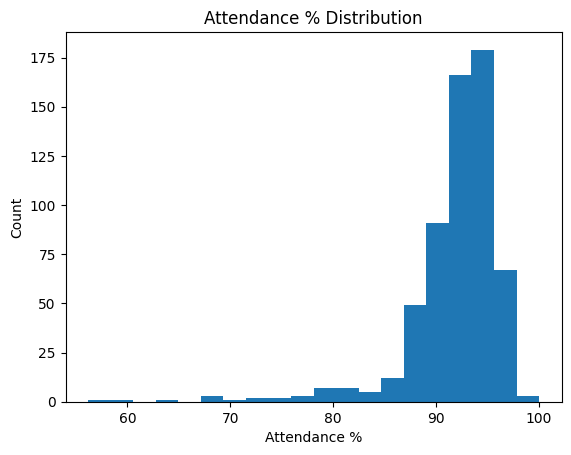

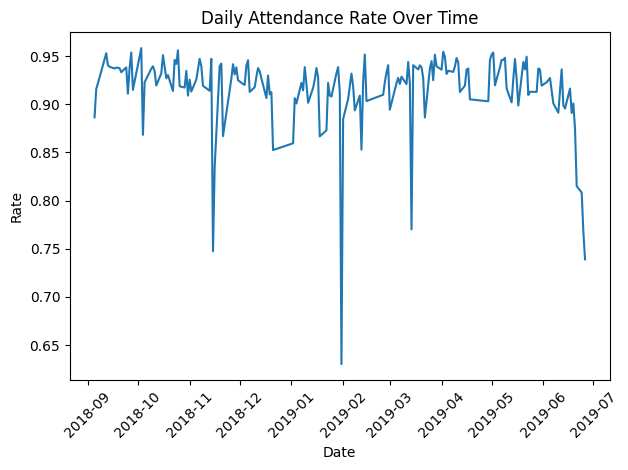

In [ ]:
import matplotlib.pyplot as plt

# Attendance percent distribution
plt.figure()
agg['Attendance_Percent'].dropna().plot(kind='hist', bins=20)
plt.title('Attendance % Distribution')
plt.xlabel('Attendance %')
plt.ylabel('Count')
plt.show()

# Daily attendance rate
plt.figure()
plt.plot(daily['Date'], daily['Daily_Attendance_Rate'])
plt.title('Daily Attendance Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Already saved earlier, but you can add reasons/thresholds:
low_attn[['Roll_No','Email','Attendance_Percent','Effective_Enrolled','Total_Present','Notification_Message']].to_csv(
    'low_attendance_notifications.csv', index=False
)


In [ ]:
# Students below threshold as of the latest date in dataset
latest_date = df['Date'].max()
print("Latest date in data:", latest_date.date())

# As % is computed over all rows so far, you can also filter to a date range if needed:
# e.g., last 30 days window:
# start = latest_date - pd.Timedelta(days=30)
# df_window = df[(df['Date']>=start) & (df['Date']<=latest_date)]
# ... recompute agg over df_window similarly if you want rolling-window attendance


Latest date in data: 2019-06-26


In [ ]:
from google.colab import files

# Download each file
files.download("attendance_alerts_all.csv")
files.download("attendance_alerts_low_only.csv")
files.download("low_attendance_notifications.csv")
files.download("proxy_risk_report.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(proxy_df.columns)
print(low_att_df.columns)


Index(['Roll_No', 'Total_Enrolled', 'Total_Released', 'Total_Present',
       'Total_Absent', 'Rows', 'Bad_Rows', 'Effective_Enrolled',
       'Attendance_Percent', 'Proxy_Soft_Outlier', 'Proxy_Row_Score',
       'Proxy_Row_Incidents', 'Proxy_Row_Reasons_Collected',
       'Proxy_Risk_Score', 'Proxy_Reasons'],
      dtype='object')
Index(['Roll_No', 'Email', 'Attendance_Percent', 'Effective_Enrolled',
       'Total_Present', 'Notification_Message'],
      dtype='object')


/tmp/ipython-input-2869126032.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=proxy_df, x="Proxy_Soft_Outlier", palette="coolwarm")


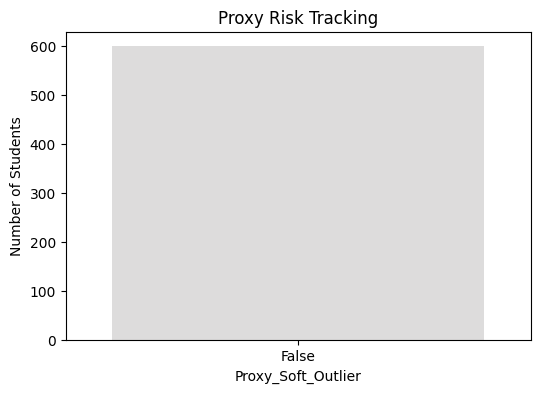

/tmp/ipython-input-2869126032.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_proxy, x="Roll_No", y="Proxy_Row_Incidents", palette="viridis")


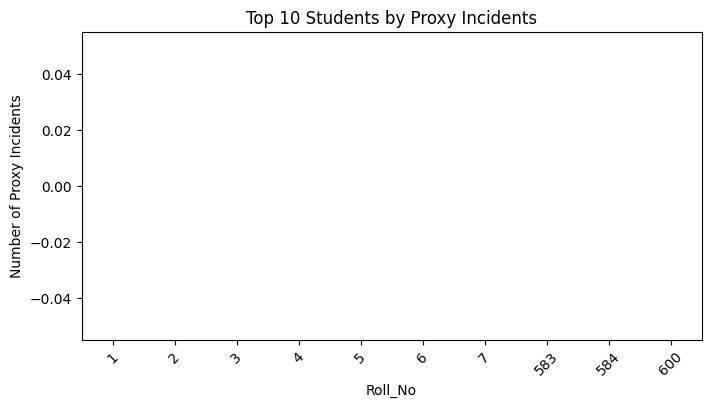

/tmp/ipython-input-2869126032.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=low_att_df, x="Low_Attendance", palette="Set2")


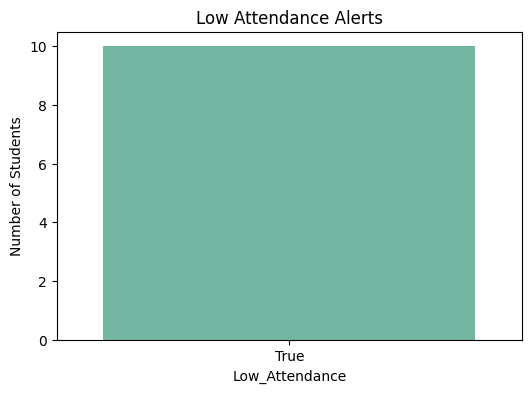

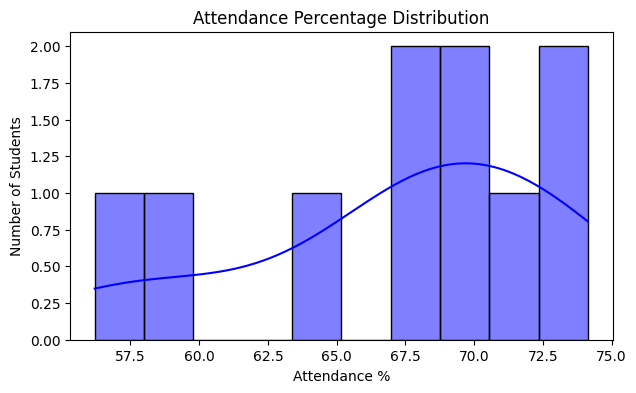

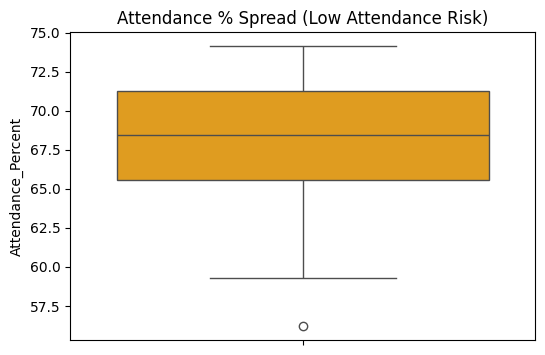

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load proxy data
proxy_df = pd.read_csv("proxy_risk_report.csv")

# 1. Count of suspected vs not suspected (Proxy_Soft_Outlier)
plt.figure(figsize=(6,4))
sns.countplot(data=proxy_df, x="Proxy_Soft_Outlier", palette="coolwarm")
plt.title("Proxy Risk Tracking")
plt.ylabel("Number of Students")
plt.savefig('proxy_risk_tracking.png')  # Save figure
plt.show()

# 2. Bar plot of top 10 students with highest proxy incidents
top_proxy = proxy_df.sort_values("Proxy_Row_Incidents", ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(data=top_proxy, x="Roll_No", y="Proxy_Row_Incidents", palette="viridis")
plt.title("Top 10 Students by Proxy Incidents")
plt.xticks(rotation=45)
plt.ylabel("Number of Proxy Incidents")
plt.savefig('proxy_bar_chart.png')  # Save figure
plt.show()

# Load low attendance data
low_att_df = pd.read_csv("low_attendance_notifications.csv")

# 1. Count how many students are below 75%
plt.figure(figsize=(6,4))
# Create a new column to mark Low Attendance Alert
low_att_df['Low_Attendance'] = low_att_df['Attendance_Percent'] < 75
sns.countplot(data=low_att_df, x="Low_Attendance", palette="Set2")
plt.title("Low Attendance Alerts")
plt.ylabel("Number of Students")
plt.savefig('attendance_low_alerts.png')
plt.show()

# 2. Histogram of Attendance_Percent
plt.figure(figsize=(7,4))
sns.histplot(low_att_df["Attendance_Percent"], bins=10, kde=True, color="blue")
plt.title("Attendance Percentage Distribution")
plt.xlabel("Attendance %")
plt.ylabel("Number of Students")
plt.savefig('attendance_histogram.png')
plt.show()

# 3. Boxplot to spot students with very low attendance
plt.figure(figsize=(6,4))
sns.boxplot(data=low_att_df, y="Attendance_Percent", color="orange")
plt.title("Attendance % Spread (Low Attendance Risk)")
plt.savefig('attendance_boxplot.png')
plt.show()
